# Setup

In [1]:
!pip install pandas numpy kaggle matplotlib tqdm scikit-image scipy

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import csv
import scipy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from skimage import io, color, util, exposure
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_rel

# Data Exploration / Cleaning

In [3]:
# Show the data
data = pd.read_csv('lung_colon_data.csv')
data

,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,LBP_10,...,LAB_504,LAB_505,LAB_506,LAB_507,LAB_508,LAB_509,LAB_510,LAB_511,LAB_512,Class
0,0.030987,0.048928,0.068682,0.167499,0.284717,0.177182,0.074558,0.046365,0.035322,0.065760,...,0.000003,0.000000,0.000002,0.000002,0.000002,0.000000,0.000002,0.000000,0.000002,0.0
1,0.036246,0.054910,0.072827,0.164154,0.250829,0.170300,0.080460,0.053260,0.041204,0.075811,...,0.000005,0.000012,0.000003,0.000002,0.000005,0.000002,0.000005,0.000003,0.000002,0.0
2,0.020311,0.034029,0.058177,0.183870,0.351113,0.182639,0.063071,0.034595,0.026354,0.045841,...,0.000000,0.000007,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.0
3,0.028783,0.045778,0.067100,0.171470,0.283529,0.177472,0.071837,0.045217,0.046339,0.062476,...,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000002,0.000000,0.000002,0.0
4,0.036112,0.054921,0.068670,0.156313,0.266729,0.172099,0.073898,0.051568,0.044674,0.075016,...,0.000019,0.000012,0.000003,0.000002,0.000005,0.000000,0.000003,0.000000,0.000002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.015639,0.034378,0.047080,0.168371,0.333852,0.212285,0.074126,0.034741,0.032303,0.047226,...,0.000005,0.000002,0.000003,0.000002,0.000003,0.000003,0.000000,0.000005,0.000003,4.0
24996,0.014709,0.033959,0.044681,0.166936,0.336305,0.210058,0.071440,0.036991,0.037103,0.047818,...,0.000059,0.000129,0.000034,0.000000,0.000000,0.000002,0.000051,0.000002,0.000005,4.0
24997,0.012246,0.026593,0.041901,0.171097,0.396783,0.206785,0.058517,0.027429,0.023432,0.035217,...,0.000010,0.000005,0.000010,0.000000,0.000000,0.000007,0.000000,0.000000,0.000003,4.0
24998,0.010011,0.023960,0.038544,0.173308,0.390537,0.216670,0.061269,0.026705,0.025389,0.033608,...,0.000000,0.000005,0.000005,0.000000,0.000008,0.000000,0.000000,0.000000,0.000003,4.0


In [4]:
# Split data
labels = data['Class']
features = data.drop('Class', axis=1)

# Remove duplicate data from each class using cosine_similarity
images_indices = []

for class_label in labels.unique():
    class_indices = labels[labels == class_label].index
    class_features = features.loc[class_indices]
    top_class_indices = []
    
    # Find cosine similarity
    similarity_matrix = cosine_similarity(class_features)
    # Sum up for all
    similarity_sums = similarity_matrix.sum(axis=1)
    # Map to index
    similarity_with_indices = list(zip(similarity_sums, class_indices))
    # Sort
    sorted_similarity = sorted(similarity_with_indices, key=lambda x: x[0])
    # Take the least similar 250 images for each class
    top_class_indices = [x[1] for x in sorted_similarity[:250]]

    images_indices.extend(top_class_indices)

cleaned = data.iloc[images_indices, :]

In [5]:
# Split data into lbp and color only variants
y = cleaned['Class']
features_cleaned = cleaned.drop('Class', axis=1)
data_lbp = features_cleaned.iloc[:,:10]
data_lab = features_cleaned.iloc[:,10:]

In [6]:
class_counts = y.value_counts()
print(cleaned.shape)
print(class_counts)

(1250, 523)
Class
0.0    250
1.0    250
2.0    250
3.0    250
4.0    250
Name: count, dtype: int64


In [7]:
data_lbp

,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,LBP_10
537,0.009189,0.021462,0.026550,0.103414,0.215129,0.166073,0.039773,0.027866,0.215590,0.174954
924,0.012383,0.024712,0.032010,0.112479,0.214789,0.176005,0.044195,0.029404,0.221741,0.132282
1997,0.012943,0.026323,0.032766,0.112272,0.211031,0.175547,0.046014,0.030833,0.201789,0.150482
3640,0.013487,0.026420,0.032944,0.113642,0.210275,0.175888,0.046666,0.030911,0.203337,0.146430
5621,0.013487,0.026420,0.032944,0.113642,0.210275,0.175888,0.046666,0.030911,0.203337,0.146430
...,...,...,...,...,...,...,...,...,...,...
23787,0.018487,0.040722,0.051804,0.170566,0.299705,0.198257,0.080563,0.042987,0.041038,0.055871
22123,0.019175,0.036197,0.054747,0.179489,0.333479,0.190352,0.070287,0.037474,0.029990,0.048809
16688,0.016459,0.034968,0.049508,0.172372,0.333138,0.204244,0.073390,0.035955,0.032347,0.047619
16646,0.016344,0.036981,0.045013,0.160663,0.326999,0.210297,0.074410,0.038617,0.039424,0.051253


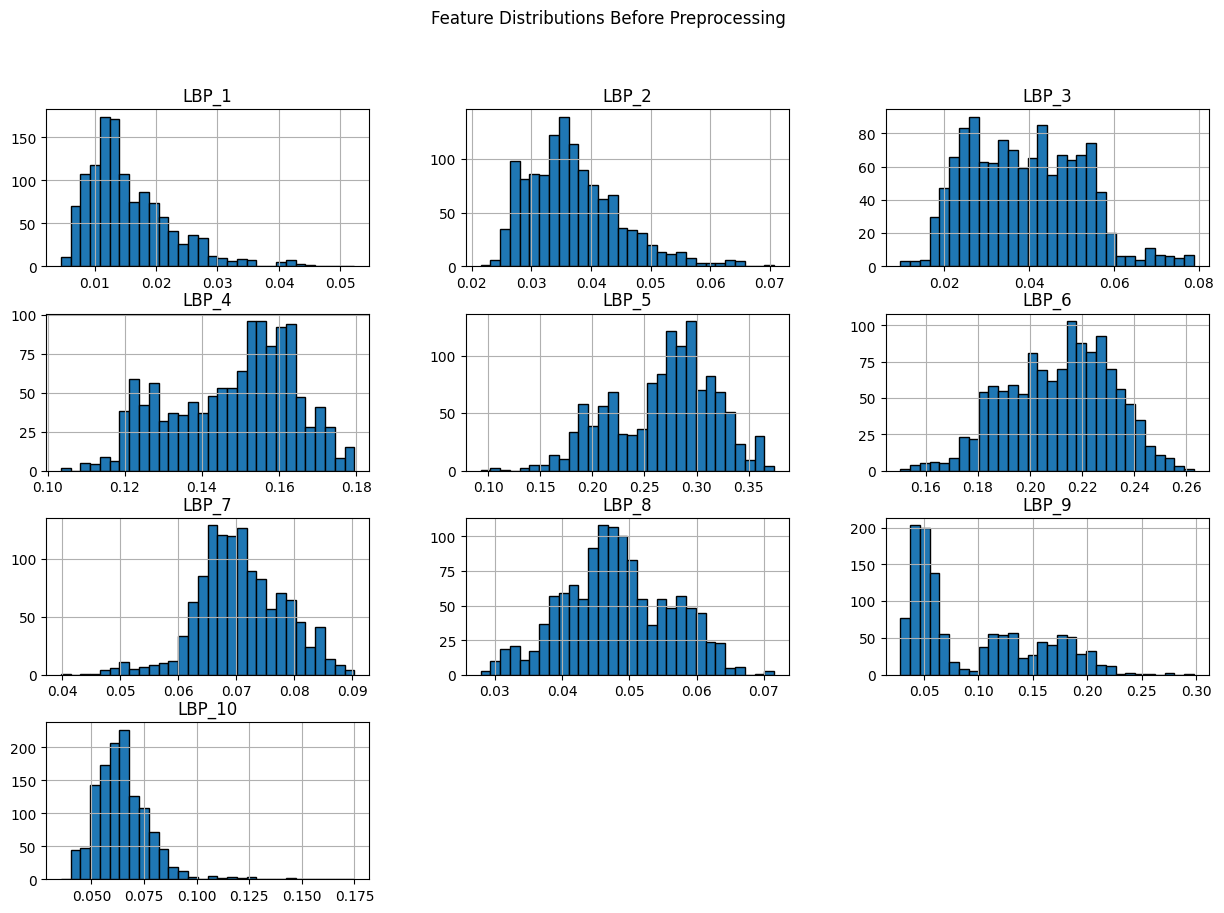

In [8]:
# Plot histograms for each feature
data_lbp.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Feature Distributions Before Preprocessing')
plt.show()

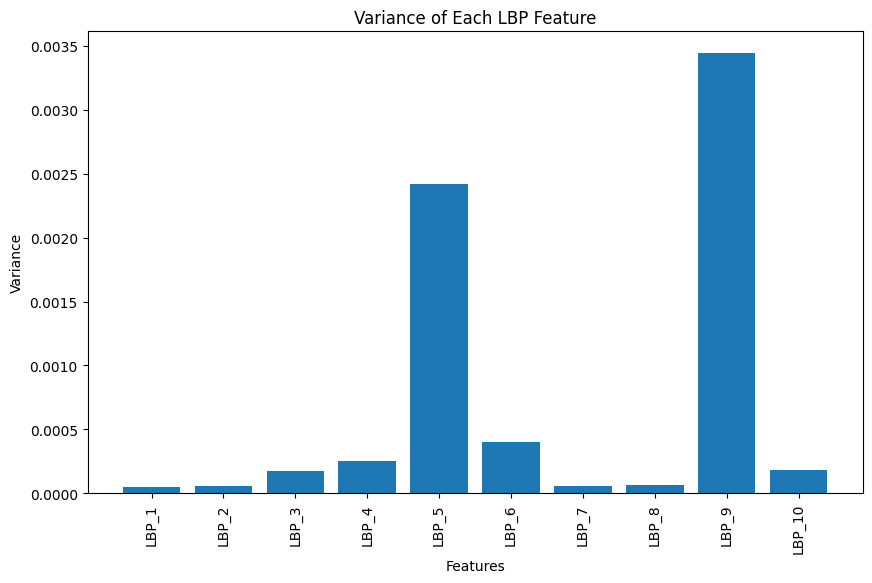

In [9]:
variances = data_lbp.var()

# Step 2: Plot the variance of each feature
plt.figure(figsize=(10, 6))
plt.bar(data_lbp.columns, variances)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Each LBP Feature')
plt.xticks(rotation=90)
plt.show()

In [10]:
data_lab

,LAB_1,LAB_2,LAB_3,LAB_4,LAB_5,LAB_6,LAB_7,LAB_8,LAB_9,LAB_10,...,LAB_503,LAB_504,LAB_505,LAB_506,LAB_507,LAB_508,LAB_509,LAB_510,LAB_511,LAB_512
537,0.000003,0.000000,0.000002,0.000002,0.000000,0.000012,0.000007,0.000007,0.000008,0.000014,...,0.000000,0.000002,0.000003,0.000003,0.000000,0.000002,0.000000,0.000000,0.000000,0.000003
924,0.000002,0.000002,0.000000,0.000000,0.000002,0.000002,0.000003,0.000000,0.000005,0.000007,...,0.000012,0.000015,0.000008,0.000002,0.000000,0.000007,0.000000,0.000007,0.000005,0.000007
1997,0.000003,0.000003,0.000002,0.000003,0.000000,0.000002,0.000002,0.000003,0.000007,0.000005,...,0.000041,0.000010,0.000007,0.000005,0.000005,0.000005,0.000002,0.000005,0.000002,0.000007
3640,0.000003,0.000002,0.000000,0.000000,0.000002,0.000000,0.000002,0.000005,0.000000,0.000008,...,0.000017,0.000008,0.000008,0.000015,0.000008,0.000000,0.000007,0.000000,0.000000,0.000003
5621,0.000003,0.000002,0.000000,0.000000,0.000002,0.000000,0.000002,0.000005,0.000000,0.000008,...,0.000017,0.000008,0.000008,0.000015,0.000008,0.000000,0.000007,0.000000,0.000000,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23787,0.000003,0.000000,0.000000,0.000000,0.000003,0.000010,0.000003,0.000010,0.000022,0.000003,...,0.000046,0.000105,0.000029,0.000000,0.000008,0.000015,0.000020,0.000000,0.000003,0.000003
22123,0.000005,0.000000,0.000003,0.000015,0.000005,0.000025,0.000044,0.000007,0.000010,0.000000,...,0.000022,0.000061,0.000061,0.000025,0.000010,0.000003,0.000003,0.000002,0.000000,0.000020
16688,0.000002,0.000000,0.000000,0.000002,0.000002,0.000000,0.000002,0.000002,0.000003,0.000005,...,0.000002,0.000000,0.000007,0.000000,0.000002,0.000002,0.000000,0.000005,0.000003,0.000002
16646,0.000007,0.000005,0.000022,0.000007,0.000012,0.000047,0.000061,0.000081,0.000109,0.000063,...,0.000022,0.000000,0.000003,0.000046,0.000003,0.000005,0.000008,0.000000,0.000000,0.000002


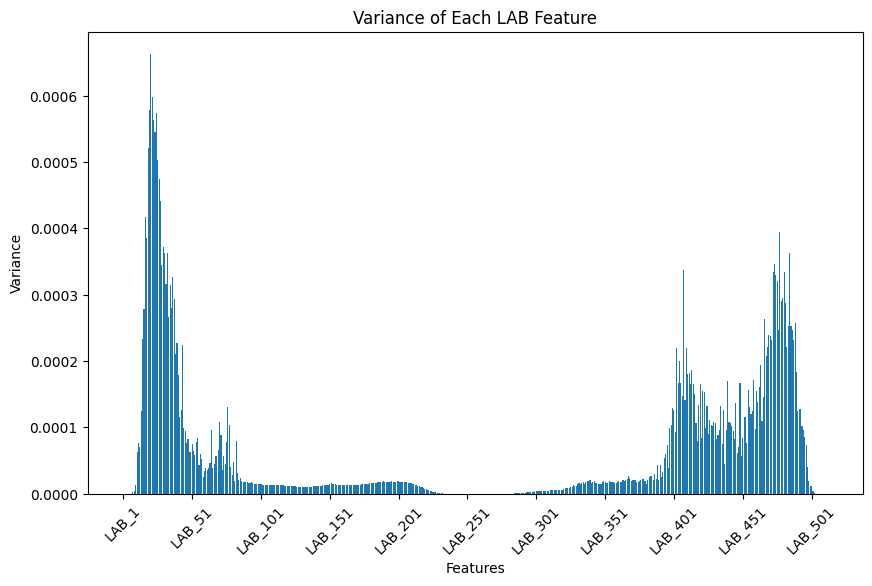

In [11]:
variances = data_lab.var()
plt.figure(figsize=(10, 6))
plt.bar(data_lab.columns, variances)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Each LAB Feature')
step = 50
plt.xticks(ticks=range(0, len(data_lab.columns), step), labels=data_lab.columns[::step], rotation=45)
plt.show()

# Split Datasets

In [12]:
# Raw dataset
X_both_train, X_both_test, y_both_train, y_both_test = train_test_split(features_cleaned, y, test_size = 0.20, random_state=10)

# LBP data
X_lbp_train, X_lbp_test, y_lbp_train, y_lbp_test = train_test_split(data_lbp, y, test_size = 0.20, random_state=10)

# Lab data
X_lab_train, X_lab_test, y_lab_train, y_lab_test = train_test_split(data_lab, y, test_size = 0.20, random_state=10)

# LBP Decision Tree

In [13]:
lbp_selector = VarianceThreshold()
lbp_dtc = DecisionTreeClassifier(random_state=10)

lbp_pipeline = Pipeline([
    ('selector', lbp_selector),
    ('classifier', lbp_dtc)
])

lbp_param_grid = {
    'selector__threshold': [0, 5e-4, 1e-4, 2e-4],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__min_samples_split': [2, 3, 5]
}

lbp_grid_search = GridSearchCV(lbp_pipeline, lbp_param_grid, cv=10, scoring=('accuracy', 'f1_macro'), refit='accuracy')
lbp_grid_search.fit(X_lbp_train, y_lbp_train)

best_pipeline = lbp_grid_search.best_estimator_
best_selector = best_pipeline.named_steps['selector']
selected_features_count = best_selector.get_support().sum()
print(f"Number of selected features: {selected_features_count}")

lbp_results_df = pd.DataFrame(lbp_grid_search.cv_results_)
print("Best Parameters:", lbp_grid_search.best_params_)
print("Best Accuracy:", lbp_grid_search.best_score_)
print("Best F1:", lbp_results_df.iloc[lbp_grid_search.best_index_, 31])

Number of selected features: 10
Best Parameters: {'classifier__max_depth': 12, 'classifier__min_samples_split': 2, 'selector__threshold': 0}
Best Accuracy: 0.938
Best F1: 0.9377026268085468


C:\Users\yshen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
lbp_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_split,param_selector__threshold,params,split0_test_accuracy,split1_test_accuracy,...,split3_test_f1_macro,split4_test_f1_macro,split5_test_f1_macro,split6_test_f1_macro,split7_test_f1_macro,split8_test_f1_macro,split9_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,0.009467,0.000964,0.003661,0.000699,6,2,0.0000,"{'classifier__max_depth': 6, 'classifier__min_...",0.97,0.88,...,0.939385,0.929147,0.897747,0.930693,0.919683,0.950162,0.920719,0.925607,0.024043,20
1,0.004976,0.000648,0.003437,0.000796,6,2,0.0005,"{'classifier__max_depth': 6, 'classifier__min_...",0.67,0.68,...,0.654228,0.724685,0.717397,0.724409,0.680122,0.749639,0.749059,0.705389,0.033261,47
2,0.007889,0.000775,0.004079,0.000872,6,2,0.0001,"{'classifier__max_depth': 6, 'classifier__min_...",0.94,0.85,...,0.909028,0.909451,0.909474,0.940411,0.929450,0.939626,0.960952,0.919640,0.029385,22
3,0.005763,0.000853,0.003550,0.000471,6,2,0.0002,"{'classifier__max_depth': 6, 'classifier__min_...",0.94,0.87,...,0.901156,0.939442,0.908665,0.878208,0.919660,0.919323,0.850067,0.899399,0.029839,35
4,0.010132,0.001014,0.004215,0.000992,6,3,0.0000,"{'classifier__max_depth': 6, 'classifier__min_...",0.97,0.88,...,0.939385,0.929147,0.897747,0.930693,0.919683,0.950162,0.920719,0.925607,0.024043,20
5,0.005866,0.000870,0.003948,0.000786,6,3,0.0005,"{'classifier__max_depth': 6, 'classifier__min_...",0.67,0.68,...,0.654228,0.724685,0.717397,0.724409,0.680122,0.749639,0.749059,0.705389,0.033261,47
6,0.008053,0.000983,0.004488,0.001260,6,3,0.0001,"{'classifier__max_depth': 6, 'classifier__min_...",0.94,0.85,...,0.909028,0.909194,0.909474,0.940411,0.929450,0.939626,0.960952,0.919615,0.029394,23
7,0.006885,0.000742,0.003968,0.000828,6,3,0.0002,"{'classifier__max_depth': 6, 'classifier__min_...",0.94,0.87,...,0.901156,0.939442,0.908665,0.878208,0.919660,0.919323,0.850067,0.899399,0.029839,35
8,0.010293,0.001325,0.004288,0.000811,6,5,0.0000,"{'classifier__max_depth': 6, 'classifier__min_...",0.97,0.88,...,0.949332,0.929147,0.887967,0.930693,0.919683,0.950162,0.931275,0.925684,0.026483,19
9,0.005439,0.000917,0.003702,0.000683,6,5,0.0005,"{'classifier__max_depth': 6, 'classifier__min_...",0.67,0.68,...,0.654228,0.743782,0.717397,0.724409,0.680122,0.749639,0.749059,0.707299,0.034826,45


In [39]:
# Test
best_lbp = lbp_grid_search.best_estimator_
lbp_predict = best_lbp.predict(X_lbp_test)
# Evaluate on test data
print("Classification Report:")
print(classification_report(y_lbp_test, lbp_predict))
print("Confusion Matrix:\n", confusion_matrix(y_lbp_test, lbp_predict))
print("Test Accuracy:", accuracy_score(y_lbp_test, lbp_predict))
print("Test F1:", f1_score(y_lbp_test, lbp_predict, average='macro'))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89        57
         1.0       0.86      0.96      0.91        45
         2.0       0.97      0.95      0.96        41
         3.0       0.96      0.98      0.97        51
         4.0       0.98      0.96      0.97        56

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

Confusion Matrix:
 [[49  7  0  0  1]
 [ 2 43  0  0  0]
 [ 0  0 39  2  0]
 [ 0  0  1 50  0]
 [ 2  0  0  0 54]]
Test Accuracy: 0.94
Test F1: 0.9405963942295061


# LAB Decision Tree

In [16]:
rf = RandomForestClassifier(random_state=10)
rf.fit(X_lab_train, y_lab_train)

feature_importance = rf.feature_importances_

# Use SelectFromModel to select important features
sfm = SelectFromModel(rf, threshold='mean')  # Select features with importance greater than the mean importance
sfm.fit(X_lab_train, y_lab_train)

# Get selected features
selected_features = X_lab_train.columns[sfm.get_support()]
print("Number of selected Features: ", selected_features.shape[0])

# Transform training and testing sets to keep only the selected features
X_train_selected = sfm.transform(X_lab_train)
X_test_selected = sfm.transform(X_lab_test)

# Transform sets for combined model later
X_both_train_a = X_both_train.iloc[:, :10]
X_both_train_b = X_both_train.iloc[:, 10:]
X_both_test_a = X_both_test.iloc[:, :10]
X_both_test_b = X_both_test.iloc[:, 10:]

# Transform the LAB data
X_both_train_selected = sfm.transform(X_both_train_b)
X_both_test_selected = sfm.transform(X_both_test_b)

# Append the LBP data
X_both_train_selected = np.hstack((X_both_train_a, X_both_train_selected))
X_both_test_selected = np.hstack((X_both_test_a, X_both_test_selected))

# Check the final shapes
print(X_both_train_selected.shape)
print(X_both_test_selected.shape)

Number of selected Features:  159
(1000, 169)
(250, 169)


In [56]:
# DTC using features selected by RF
lab_dtc = DecisionTreeClassifier(random_state=10)

lab_param_grid = {
    'max_depth': [6, 8, 10, 12, 14],
    'min_samples_split': [2, 3, 5, 10]
}

lab_grid_search = GridSearchCV(lab_dtc, lab_param_grid, cv=10, scoring=('accuracy', 'f1_macro'), refit='accuracy')
lab_grid_search.fit(X_train_selected, y_lab_train)

# Check the best parameters
lab_results_df = pd.DataFrame(lab_grid_search.cv_results_)
print("Best parameters:", lab_grid_search.best_params_)
print("Best Accuracy:", lab_grid_search.best_score_)
print("Best F1:", lab_results_df.iloc[lab_grid_search.best_index_, 30])

Best parameters: {'max_depth': 10, 'min_samples_split': 3}
Best Accuracy: 0.9029999999999999
Best F1: 0.9038033649504957


In [19]:
lab_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,split3_test_f1_macro,split4_test_f1_macro,split5_test_f1_macro,split6_test_f1_macro,split7_test_f1_macro,split8_test_f1_macro,split9_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,0.092081,0.006610,0.002817,0.000993,6,2,"{'max_depth': 6, 'min_samples_split': 2}",0.94,0.89,0.85,...,0.890955,0.909887,0.879703,0.909307,0.814972,0.850079,0.889981,0.882653,0.033920,19
1,0.097269,0.007987,0.003703,0.000536,6,3,"{'max_depth': 6, 'min_samples_split': 3}",0.94,0.90,0.84,...,0.879327,0.929863,0.879703,0.909633,0.814972,0.860796,0.879937,0.883908,0.036238,18
2,0.098072,0.019967,0.003057,0.000939,6,5,"{'max_depth': 6, 'min_samples_split': 5}",0.94,0.92,0.84,...,0.871457,0.910563,0.860152,0.909633,0.841653,0.810272,0.879937,0.878695,0.038955,20
3,0.087615,0.004364,0.002956,0.000515,6,10,"{'max_depth': 6, 'min_samples_split': 10}",0.94,0.92,0.85,...,0.878009,0.910225,0.889099,0.919801,0.822808,0.860271,0.890128,0.888341,0.034217,17
4,0.107264,0.010947,0.002913,0.000733,8,2,"{'max_depth': 8, 'min_samples_split': 2}",0.94,0.90,0.87,...,0.890437,0.928702,0.889612,0.918856,0.824144,0.858695,0.889450,0.890983,0.032660,16
5,0.099674,0.006579,0.003266,0.000769,8,3,"{'max_depth': 8, 'min_samples_split': 3}",0.93,0.92,0.89,...,0.891333,0.949525,0.889612,0.908576,0.823462,0.871113,0.910174,0.898313,0.032910,4
6,0.096147,0.005167,0.002528,0.000464,8,5,"{'max_depth': 8, 'min_samples_split': 5}",0.94,0.95,0.85,...,0.868216,0.919927,0.909017,0.909414,0.853566,0.841138,0.909961,0.895114,0.037072,9
7,0.106247,0.008765,0.002912,0.000916,8,10,"{'max_depth': 8, 'min_samples_split': 10}",0.94,0.94,0.86,...,0.878033,0.919893,0.939780,0.929590,0.832179,0.830776,0.889679,0.896066,0.041900,8
8,0.108176,0.005685,0.002707,0.000896,10,2,"{'max_depth': 10, 'min_samples_split': 2}",0.94,0.91,0.87,...,0.878104,0.939158,0.900299,0.939675,0.811272,0.858695,0.889981,0.893757,0.039388,13
9,0.102489,0.006270,0.002994,0.000829,10,3,"{'max_depth': 10, 'min_samples_split': 3}",0.93,0.92,0.89,...,0.910645,0.949525,0.899434,0.940766,0.824144,0.863561,0.910174,0.903803,0.035567,1


In [40]:
# Test
best_lab = lab_grid_search.best_estimator_
lab_predict = best_lab.predict(X_test_selected)
# Evaluate on test data
print("Classification Report:")
print(classification_report(y_lab_test, lab_predict))
print("Confusion Matrix:\n", confusion_matrix(y_lab_test, lab_predict))
print("Test Accuracy:", accuracy_score(y_lab_test, lab_predict))
print("Test F1:", f1_score(y_lab_test, lab_predict, average='macro'))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        57
         1.0       0.80      0.87      0.83        45
         2.0       0.95      0.88      0.91        41
         3.0       0.90      0.92      0.91        51
         4.0       0.94      0.79      0.85        56

    accuracy                           0.87       250
   macro avg       0.88      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250

Confusion Matrix:
 [[51  4  1  1  0]
 [ 4 39  1  0  1]
 [ 1  1 36  1  2]
 [ 1  3  0 47  0]
 [ 7  2  0  3 44]]
Test Accuracy: 0.868
Test F1: 0.87022902739591


In [21]:
lab_selector = VarianceThreshold()
lab_var_dtc = DecisionTreeClassifier(random_state=10)

lab_var_pipeline = Pipeline([
    ('selector', lab_selector),
    ('classifier', lab_var_dtc)
])

lab_var_param_grid = {
    'selector__threshold': [0, 5e-4, 1e-4, 2e-4],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__min_samples_split': [2, 3, 5, 10]
}

lab_var_grid_search = GridSearchCV(lab_var_pipeline, lab_var_param_grid, cv=10, scoring=('accuracy', 'f1_macro'), refit='accuracy')
lab_var_grid_search.fit(X_lab_train, y_lab_train)

best_lab_pipeline = lab_var_grid_search.best_estimator_
best_lab_selector = best_lab_pipeline.named_steps['selector']
selected_lab_features_count = best_lab_selector.get_support().sum()
print(f"Number of selected features: {selected_lab_features_count}")

# Check the best parameters
lab_var_results_df = pd.DataFrame(lab_var_grid_search.cv_results_)
print("Best parameters:", lab_var_grid_search.best_params_)
print("Best Accuracy:", lab_var_grid_search.best_score_)
print("Best F1:", lab_var_results_df.iloc[lab_var_grid_search.best_index_, 31])

C:\Users\yshen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Number of selected features: 512
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 3, 'selector__threshold': 0}
Best score: 0.8850000000000001
Best F1: 0.8843588425183494


In [22]:
lab_var_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_split,param_selector__threshold,params,split0_test_accuracy,split1_test_accuracy,...,split3_test_f1_macro,split4_test_f1_macro,split5_test_f1_macro,split6_test_f1_macro,split7_test_f1_macro,split8_test_f1_macro,split9_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,0.286784,0.018411,0.006504,0.001289,6,2,0.0000,"{'classifier__max_depth': 6, 'classifier__min_...",0.90,0.89,...,0.888947,0.869397,0.888760,0.888555,0.789188,0.889130,0.859340,0.870562,0.031435,16
1,0.019077,0.001572,0.006151,0.000873,6,2,0.0005,"{'classifier__max_depth': 6, 'classifier__min_...",0.51,0.55,...,0.443098,0.614029,0.389801,0.514644,0.536779,0.486064,0.478846,0.500032,0.056871,63
2,0.083649,0.001355,0.006538,0.000918,6,2,0.0001,"{'classifier__max_depth': 6, 'classifier__min_...",0.75,0.84,...,0.702300,0.842180,0.759251,0.762965,0.851275,0.880194,0.782144,0.789512,0.057157,28
3,0.047065,0.003969,0.006346,0.001103,6,2,0.0002,"{'classifier__max_depth': 6, 'classifier__min_...",0.71,0.78,...,0.639338,0.740117,0.716061,0.777749,0.784352,0.722143,0.720736,0.725375,0.046168,45
4,0.274006,0.020587,0.005586,0.001170,6,3,0.0000,"{'classifier__max_depth': 6, 'classifier__min_...",0.90,0.88,...,0.870762,0.880902,0.888760,0.888555,0.789188,0.879179,0.870163,0.870701,0.028950,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.055683,0.003390,0.005437,0.000776,12,5,0.0002,"{'classifier__max_depth': 12, 'classifier__min...",0.80,0.83,...,0.717515,0.788105,0.762540,0.818394,0.817446,0.789753,0.749221,0.782204,0.034136,36
60,0.316377,0.016769,0.007081,0.000862,12,10,0.0000,"{'classifier__max_depth': 12, 'classifier__min...",0.93,0.92,...,0.880600,0.850597,0.909424,0.898911,0.823893,0.869155,0.860425,0.879090,0.032420,5
61,0.020025,0.001172,0.006122,0.000827,12,10,0.0005,"{'classifier__max_depth': 12, 'classifier__min...",0.56,0.57,...,0.665282,0.648805,0.559381,0.674480,0.669328,0.621978,0.617361,0.625194,0.043915,51
62,0.106366,0.004888,0.006271,0.001142,12,10,0.0001,"{'classifier__max_depth': 12, 'classifier__min...",0.77,0.79,...,0.741191,0.839703,0.709073,0.802277,0.859284,0.838955,0.785704,0.787865,0.045937,30


In [41]:
# Test
best_var_lab = lab_var_grid_search.best_estimator_
lab_var_predict = best_var_lab.predict(X_lab_test)
# Evaluate on test data
print("Classification Report:")
print(classification_report(y_lab_test, lab_var_predict))
print("Confusion Matrix:\n", confusion_matrix(y_lab_test, lab_var_predict))
print("Test Accuracy:", accuracy_score(y_lab_test, lab_var_predict))
print("Test F1:", f1_score(y_lab_test, lab_var_predict, average='macro'))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83        57
         1.0       0.88      0.82      0.85        45
         2.0       0.92      0.85      0.89        41
         3.0       0.94      0.92      0.93        51
         4.0       0.91      0.88      0.89        56

    accuracy                           0.88       250
   macro avg       0.88      0.87      0.88       250
weighted avg       0.88      0.88      0.88       250

Confusion Matrix:
 [[51  3  0  2  1]
 [ 7 37  0  0  1]
 [ 2  1 35  1  2]
 [ 2  0  1 47  1]
 [ 4  1  2  0 49]]
Test Accuracy: 0.876
Test F1: 0.877504222981943


# Combined Decision Tree

In [24]:
class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self, selector1):
        self.selector1 = selector1

    def fit(self, X, y=None):
        self.selector1.fit(X[:, :10], y)
        self.selected_features_count = self.selector1.get_support().sum()
        return self

    def transform(self, X):
        selected_data1 = self.selector1.transform(X[:, :10])
        selected_data2 = X[:, 10:]
        combined_data = np.hstack((selected_data1, selected_data2))
        return combined_data

In [25]:
# Use same RF to feature select
selector1 = VarianceThreshold()

both_dtc = DecisionTreeClassifier(random_state=10)

data_merger = DataMerger(selector1=selector1)

both_pipeline = Pipeline([
    ('merger', data_merger),
    ('classifier', both_dtc)
])

both_param_grid = {
    'merger__selector1__threshold': [0, 5e-4, 1e-4, 2e-4],
    'classifier__max_depth': [4, 6, 8, 10, 12],
    'classifier__min_samples_split': [2, 3, 5, 10]
}

both_grid_search = GridSearchCV(both_pipeline, both_param_grid, cv=10, scoring=('accuracy', 'f1_macro'), refit='accuracy')
both_grid_search.fit(X_both_train_selected, y_both_train)

best_pipeline = both_grid_search.best_estimator_
print(f"Number of selected features: {best_pipeline.named_steps['merger'].selected_features_count}")

# Check the best parameters
both_results_df = pd.DataFrame(both_grid_search.cv_results_)
print("Best parameters:", both_grid_search.best_params_)
print("Best Accuracy:", both_grid_search.best_score_)
print("Best F1:", both_results_df.iloc[both_grid_search.best_index_, 31])

Number of selected features: 10
Best parameters: {'classifier__max_depth': 8, 'classifier__min_samples_split': 3, 'merger__selector1__threshold': 0}
Best score: 0.9710000000000001
Best F1: 0.9705592832372314


In [26]:
both_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_split,param_merger__selector1__threshold,params,split0_test_accuracy,split1_test_accuracy,...,split3_test_f1_macro,split4_test_f1_macro,split5_test_f1_macro,split6_test_f1_macro,split7_test_f1_macro,split8_test_f1_macro,split9_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,0.073407,0.003542,0.003270,0.000701,4,2,0.0000,"{'classifier__max_depth': 4, 'classifier__min_...",0.97,0.98,...,0.929956,0.909237,0.968455,0.979365,0.898346,0.960181,0.961305,0.950680,0.027271,61
1,0.065314,0.002549,0.003072,0.000642,4,2,0.0005,"{'classifier__max_depth': 4, 'classifier__min_...",0.93,0.96,...,0.919956,0.899534,0.958254,0.923093,0.887791,0.949291,0.960952,0.932688,0.024180,73
2,0.064610,0.001960,0.002962,0.000632,4,2,0.0001,"{'classifier__max_depth': 4, 'classifier__min_...",0.96,0.96,...,0.929956,0.909237,0.968455,0.947475,0.890014,0.960181,0.961305,0.942564,0.024403,69
3,0.066963,0.003935,0.002964,0.000600,4,2,0.0002,"{'classifier__max_depth': 4, 'classifier__min_...",0.93,0.95,...,0.920725,0.878766,0.958254,0.923093,0.879146,0.949291,0.960952,0.928792,0.028056,77
4,0.073574,0.008548,0.002727,0.000614,4,3,0.0000,"{'classifier__max_depth': 4, 'classifier__min_...",0.97,0.98,...,0.929956,0.909237,0.968455,0.979365,0.898346,0.960181,0.961305,0.950680,0.027271,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.082566,0.004703,0.002392,0.000428,12,5,0.0002,"{'classifier__max_depth': 12, 'classifier__min...",0.96,0.97,...,0.949969,0.959474,0.979717,0.957423,0.898346,0.968906,0.940909,0.954107,0.021171,41
76,0.081281,0.005257,0.002997,0.000394,12,10,0.0000,"{'classifier__max_depth': 12, 'classifier__min...",0.97,0.98,...,0.969981,0.958875,0.969365,0.989717,0.908649,0.979467,0.979994,0.967535,0.021218,9
77,0.078540,0.003027,0.002790,0.000577,12,10,0.0005,"{'classifier__max_depth': 12, 'classifier__min...",0.95,0.95,...,0.959435,0.939173,0.979474,0.957423,0.878515,0.968906,0.930958,0.949266,0.028006,66
78,0.084291,0.006286,0.002912,0.000479,12,10,0.0001,"{'classifier__max_depth': 12, 'classifier__min...",0.97,0.97,...,0.969981,0.958875,0.968906,1.000000,0.899804,0.979467,0.960696,0.964706,0.024184,23


In [42]:
# Test
best_both = both_grid_search.best_estimator_
both_predict = best_both.predict(X_both_test_selected)
# Evaluate on test data
print("Classification Report:")
print(classification_report(y_both_test, both_predict))
print("Confusion Matrix:\n", confusion_matrix(y_both_test, both_predict))
print("Test Accuracy:", accuracy_score(y_both_test, both_predict))
print("Test F1:", f1_score(y_both_test, both_predict, average='macro'))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91        57
         1.0       0.87      0.87      0.87        45
         2.0       1.00      1.00      1.00        41
         3.0       1.00      1.00      1.00        51
         4.0       0.96      0.93      0.95        56

    accuracy                           0.94       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.94      0.94      0.94       250

Confusion Matrix:
 [[53  3  0  0  1]
 [ 5 39  0  0  1]
 [ 0  0 41  0  0]
 [ 0  0  0 51  0]
 [ 1  3  0  0 52]]
Test Accuracy: 0.944
Test F1: 0.9451828631138977


In [67]:
both_var_dtc = DecisionTreeClassifier(random_state=10)

both_param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 3, 5, 10]
}

both_var_grid_search = GridSearchCV(both_var_dtc, both_param_grid, cv=10, scoring=('accuracy', 'f1_macro'), refit='accuracy')
both_var_grid_search.fit(X_both_train, y_both_train)

# Check the best parameters
both_var_results_df = pd.DataFrame(both_var_grid_search.cv_results_)
print("Best parameters:", both_var_grid_search.best_params_)
print("Best Accuracy:", both_var_grid_search.best_score_)
print("Best F1:", both_var_results_df.iloc[both_var_grid_search.best_index_, 30])

Best parameters: {'max_depth': 8, 'min_samples_split': 3}
Best Accuracy: 0.9590000000000002
Best F1: 0.9585847617583962


In [68]:
# Test
best_var_both = both_var_grid_search.best_estimator_
both_var_predict = best_var_both.predict(X_both_test)
# Evaluate on test data
print("Classification Report:")
print(classification_report(y_both_test, both_var_predict))
print("Confusion Matrix:\n", confusion_matrix(y_both_test, both_var_predict))
print("Test Accuracy:", accuracy_score(y_both_test, both_var_predict))
print("Test F1:", f1_score(y_both_test, both_var_predict, average='macro'))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90        57
         1.0       0.87      0.91      0.89        45
         2.0       1.00      1.00      1.00        41
         3.0       1.00      1.00      1.00        51
         4.0       0.96      0.91      0.94        56

    accuracy                           0.94       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.94      0.94      0.94       250

Confusion Matrix:
 [[52  3  0  0  2]
 [ 4 41  0  0  0]
 [ 0  0 41  0  0]
 [ 0  0  0 51  0]
 [ 2  3  0  0 51]]
Test Accuracy: 0.944
Test F1: 0.9462863980853611


# Comparison

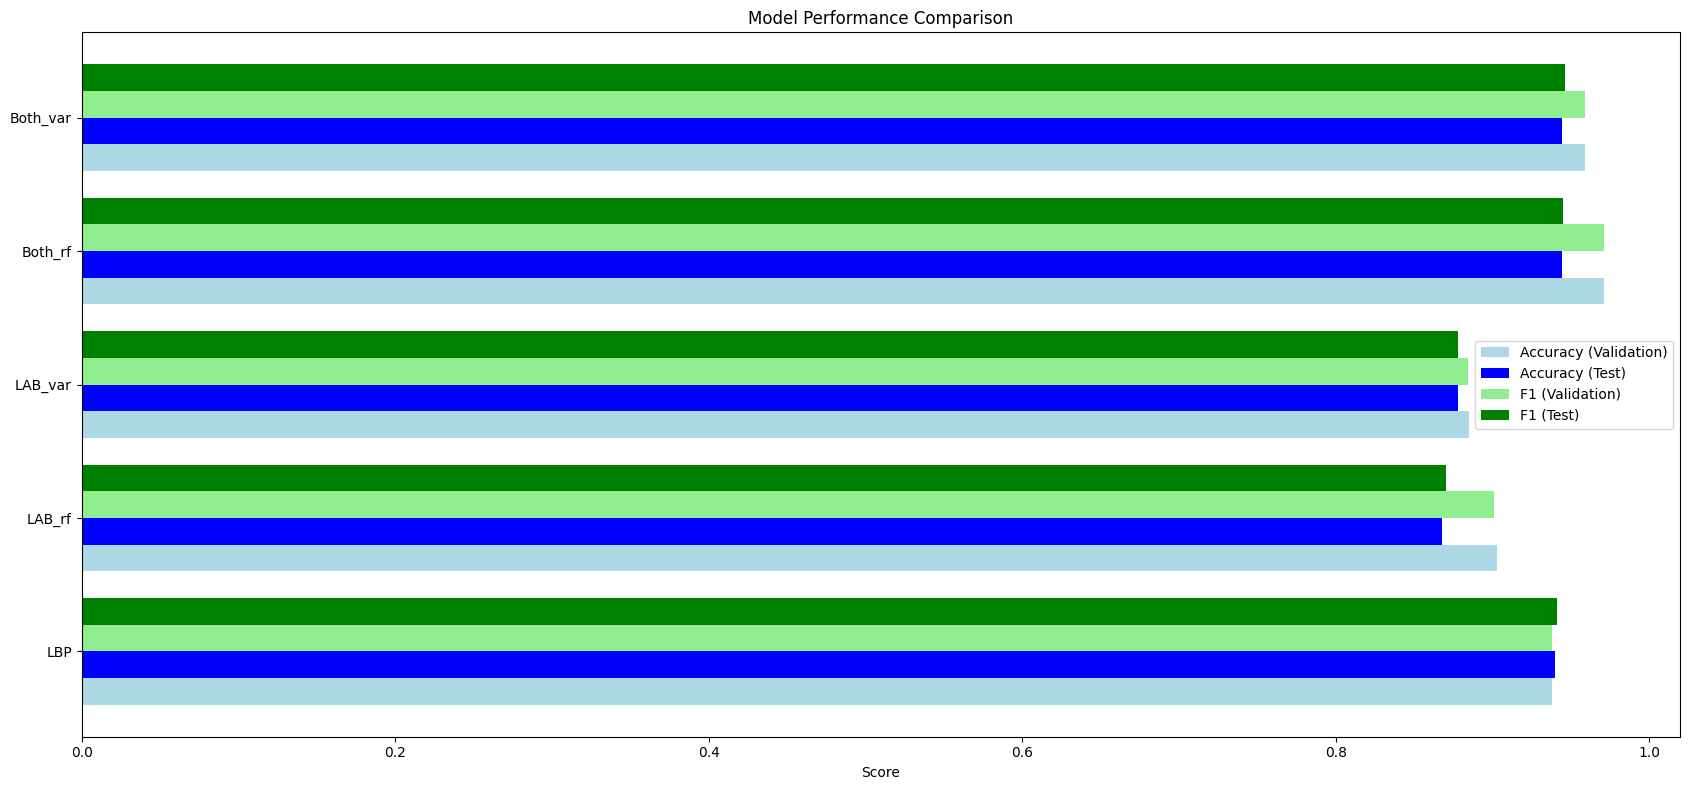

In [69]:
model_names = ['LBP', 'LAB_rf', 'LAB_var', 'Both_rf', 'Both_var']
accuracy_val = [0.938, 0.903, 0.885, 0.971, 0.959]  
accuracy_test = [0.94, 0.868, 0.878, 0.944, 0.944] 
f1_val = [0.938, 0.901, 0.884, 0.971, 0.959]  
f1_test = [0.941, 0.87, 0.878, 0.945, 0.946] 

comparison = {
    'Model': model_names,
    'Accuracy (Validation)': accuracy_val,
    'Accuracy (Test)': accuracy_test,
    'F1 (Validation)': f1_val,
    'F1 (Test)': f1_test
}
df = pd.DataFrame(comparison)

# Plotting
fig, ax = plt.subplots(figsize=(17, 8))

# Plotting accuracy and F1 scores
bar_width = 0.2
index = range(len(model_names))

# Accuracy bars
ax.barh(index, df['Accuracy (Validation)'], bar_width, label='Accuracy (Validation)', color='lightblue')
ax.barh([i + bar_width for i in index], df['Accuracy (Test)'], bar_width, label='Accuracy (Test)', color='blue')

# F1 score bars
ax.barh([i + 2 * bar_width for i in index], df['F1 (Validation)'], bar_width, label='F1 (Validation)', color='lightgreen')
ax.barh([i + 3 * bar_width for i in index], df['F1 (Test)'], bar_width, label='F1 (Test)', color='green')

# Labeling
ax.set_xlabel('Score')
ax.set_yticks([i + 1.5 * bar_width for i in index])  # Adjust y-ticks to center the bars
ax.set_yticklabels(model_names)
ax.set_title('Model Performance Comparison')

# Add a legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [85]:
lbp_scores = lbp_results_df.iloc[lbp_grid_search.best_index_, 8:18].to_numpy().ravel()

lab_scores = lab_results_df.iloc[lab_grid_search.best_index_, 8:18].to_numpy().ravel()

both_scores = both_results_df.iloc[both_grid_search.best_index_, 9:19].to_numpy().ravel()

In [88]:
t_stat, p_value = ttest_rel(lbp_scores, both_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.910264902390156, P-value: 0.003563318185941061


In [89]:
t_stat, p_value = ttest_rel(lab_scores, both_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -5.505081245865655, P-value: 0.0003776951804970234
